In [79]:
import numpy as np, pandas as pd
import os, sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm


In [78]:
import statsmodels
data_dir = 'data' 

In [87]:
data_dict = {
    'energy': {
        'file': 'Energy-energydata_complete.csv',
        'time_col': 'date',
        'time_steps_per_day': 1, 
        'has_weekends': False,
        'max_lags': 250,
    },
    'stocks': {
        'file': 'Stock-GOOG.csv',
        'time_col': 'Date', 
        'time_steps_per_day': 24*6, 
        'has_weekends': True,
        'max_lags': 4320,       
    }
}

## Choose Data

In [351]:
selected = 'energy'
selected = 'stocks'

In [352]:
file_path = os.path.join(data_dir, data_dict[selected]['file'])
data = pd.read_csv(file_path, parse_dates=[data_dict[selected]['time_col']])
print(data.head())

        Date         Open         High          Low        Close    Adj Close  \
0 2020-06-29  1358.180054  1395.599976  1347.010010  1394.969971  1394.969971   
1 2020-06-30  1390.439941  1418.650024  1383.959961  1413.609985  1413.609985   
2 2020-07-01  1411.099976  1443.000000  1409.819946  1438.040039  1438.040039   
3 2020-07-02  1446.939941  1482.949951  1446.420044  1464.699951  1464.699951   
4 2020-07-06  1480.060059  1506.589966  1472.859985  1495.699951  1495.699951   

    Volume  
0  1810200  
1  2042400  
2  1775200  
3  1859100  
4  1564000  


## Extract date feature

In [353]:
time_col = data_dict[selected]['time_col']

In [354]:
data[time_col] = data[time_col].apply(lambda t: t.date())
data.head()

Date         Open         High          Low        Close  \
0  2020-06-29  1358.180054  1395.599976  1347.010010  1394.969971   
1  2020-06-30  1390.439941  1418.650024  1383.959961  1413.609985   
2  2020-07-01  1411.099976  1443.000000  1409.819946  1438.040039   
3  2020-07-02  1446.939941  1482.949951  1446.420044  1464.699951   
4  2020-07-06  1480.060059  1506.589966  1472.859985  1495.699951   

     Adj Close   Volume  
0  1394.969971  1810200  
1  1413.609985  2042400  
2  1438.040039  1775200  
3  1464.699951  1859100  
4  1495.699951  1564000

## Group data by time col

In [355]:
groupby_col = time_col
val_cols = list(data.columns)
val_cols = [c for c in val_cols if c != groupby_col]
grouped_data = data.groupby(groupby_col, as_index=False)[val_cols].sum()
grouped_data.sort_values(by=groupby_col, inplace=True)
del grouped_data[groupby_col]
grouped_data.reset_index(drop=True, inplace=True)
grouped_data.head()

Open         High          Low        Close    Adj Close   Volume
0  1358.180054  1395.599976  1347.010010  1394.969971  1394.969971  1810200
1  1390.439941  1418.650024  1383.959961  1413.609985  1413.609985  2042400
2  1411.099976  1443.000000  1409.819946  1438.040039  1438.040039  1775200
3  1446.939941  1482.949951  1446.420044  1464.699951  1464.699951  1859100
4  1480.060059  1506.589966  1472.859985  1495.699951  1495.699951  1564000

In [356]:
# save num_dim
N, D = grouped_data.shape
N, D

(252, 6)

## Train Test Split

In [357]:
train_perc = 0.8
test_perc = 1 - train_perc

N = grouped_data.shape[0]
num_train = int(N * train_perc)
num_test = N - num_train
print(N, num_train, num_test)

252 201 51


In [358]:
train_data = grouped_data.head(num_train).copy()
test_data = grouped_data.tail(num_test).copy()
print('train/test shapes:', train_data.shape, test_data.shape)

train/test shapes: (201, 6) (51, 6)


### Min Max Scale

In [359]:
scaler = MinMaxScaler()
train_data_arr = scaler.fit_transform(train_data)
test_data_arr = scaler.transform(test_data)

train_data = pd.DataFrame(train_data_arr, columns = train_data.columns, index=train_data.index)
test_data = pd.DataFrame(test_data_arr, columns = test_data.columns, index=test_data.index)

print('train/test shapes:', train_data_arr.shape, test_data_arr.shape)

train/test shapes: (201, 6) (51, 6)


In [360]:
print(train_data.min(axis=0), train_data.max(axis=0))

Open         0.0
High         0.0
Low          0.0
Close        0.0
Adj Close    0.0
Volume       0.0
dtype: float64 Open         1.0
High         1.0
Low          1.0
Close        1.0
Adj Close    1.0
Volume       1.0
dtype: float64


## Feature Correlation 

In [361]:
corr = train_data.corr()
corr 

Open      High       Low     Close  Adj Close    Volume
Open       1.000000  0.997705  0.997416  0.994862   0.994862 -0.170863
High       0.997705  1.000000  0.997395  0.997680   0.997680 -0.156811
Low        0.997416  0.997395  1.000000  0.998099   0.998099 -0.196737
Close      0.994862  0.997680  0.998099  1.000000   1.000000 -0.178579
Adj Close  0.994862  0.997680  0.998099  1.000000   1.000000 -0.178579
Volume    -0.170863 -0.156811 -0.196737 -0.178579  -0.178579  1.000000

In [362]:
mean_corr = corr.mean().mean()
mean_corr

0.6717904591079455

# Auto Correlation

### PACF Plot

lags: 99.0


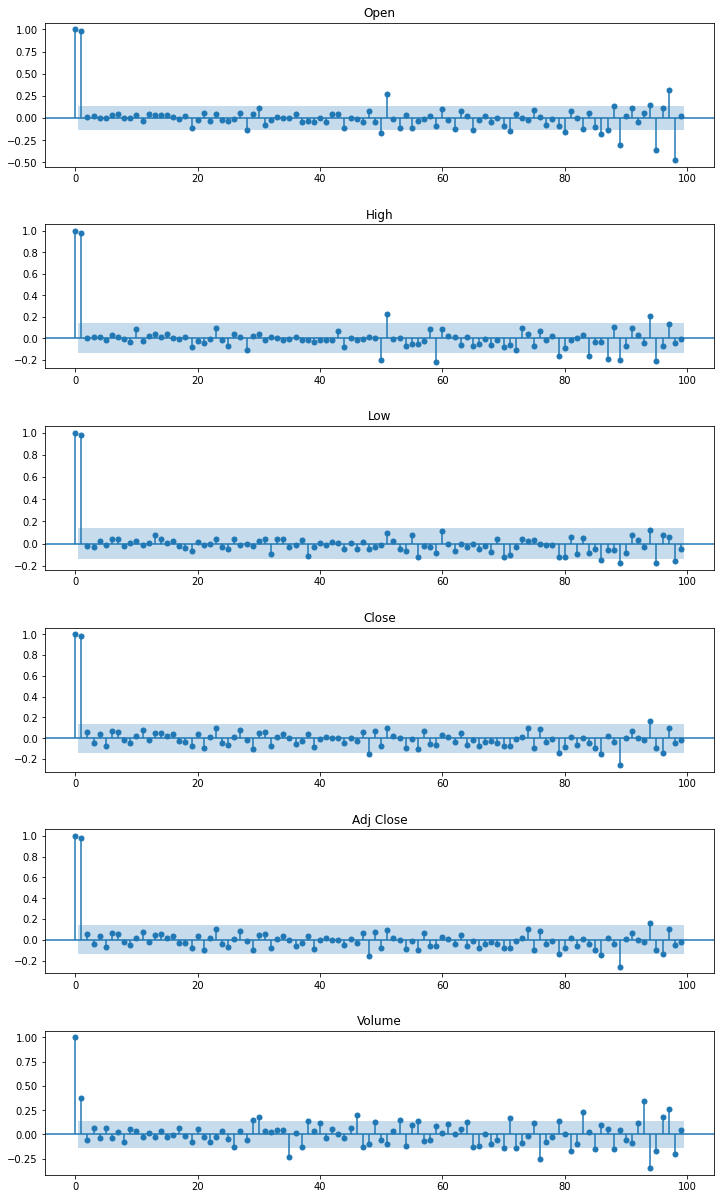

In [363]:
lags = min(data_dict[selected]['max_lags'], np.floor(train_data.shape[0] * 0.5) - 1)
print('lags:', lags)

max_plots_to_draw = 50
num_plots = min(len(val_cols), max_plots_to_draw)

figsize = (12, 2 + 3*num_plots)
fig, axs = plt.subplots(len(val_cols[: num_plots]), 1, figsize=figsize)

for i, col in enumerate(val_cols[:num_plots]):
    sm.graphics.tsa.plot_pacf(train_data[col].values.squeeze(), lags=lags, ax = axs[i])
    axs[i].set_title(col)
    
plt.subplots_adjust(top = 0.90, bottom=0.1, hspace=.4, wspace=0.4)